# Poisson equation in 1D with Dirichlet/Neurmann boundary conditions

## Problem setup

We will solve a Poisson equation:
$$
\nabla^2 u = 2, \qquad x \in [-1, 1]
$$
with the Neumann boundary condtions on the right boundary
$$
\left. \dfrac{du}{dx} \right|_{x=1} = 4
$$
and Dirichlet boundary conditions on the left boundary
$$
u(-1) = 0.
$$

The exact solution is $u(x) = (x+1)^2$

## Implementation

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [3]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-09 08:36:44.039477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 08:36:44.039521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 08:36:44.039554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 08:36:44.047794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [4]:
geom = dde.geometry.Interval(-1, 1)

In [5]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - 2

In [6]:
def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], -1)

In [7]:
def true_solution(x):
    return (x+1)**2

def func_N(x):
    return 4

def func_D(x):
    return 0

In [8]:
bc_r = dde.icbc.NeumannBC(geom, func_N, boundary_r)
bc_l = dde.icbc.DirichletBC(geom, func_D, boundary_l)

In [9]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_r, bc_l],
                    num_domain=16,
                    num_boundary=2,
                    solution=true_solution,
                    num_test=100)

In [10]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

2023-10-09 08:41:40.700549: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-09 08:41:40.701454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


In [12]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.005381 s



In [14]:
loss_histroy, train_state = model.train(iterations=int(1e4))

Training model...

0         [3.98e+00, 1.11e+01, 6.14e-01]    [4.04e+00, 1.11e+01, 6.14e-01]    [8.55e-01]    
1000      [2.98e-04, 1.38e-05, 3.18e-05]    [2.09e-04, 1.38e-05, 3.18e-05]    [2.20e-03]    
2000      [1.32e-04, 7.70e-09, 6.20e-10]    [1.14e-04, 7.78e-09, 6.20e-10]    [5.92e-04]    
3000      [9.45e-05, 6.34e-09, 3.80e-09]    [8.21e-05, 6.34e-09, 3.80e-09]    [6.01e-04]    
4000      [6.93e-05, 3.96e-06, 9.15e-06]    [5.93e-05, 3.96e-06, 9.15e-06]    [1.31e-03]    
5000      [4.92e-05, 5.68e-08, 1.10e-07]    [4.20e-05, 5.68e-08, 1.10e-07]    [5.08e-04]    
6000      [3.64e-05, 2.70e-09, 2.25e-09]    [3.04e-05, 2.75e-09, 2.25e-09]    [3.91e-04]    
7000      [2.59e-05, 4.01e-10, 1.49e-11]    [2.09e-05, 4.40e-10, 1.49e-11]    [3.00e-04]    
8000      [3.04e-05, 1.48e-04, 1.93e-04]    [2.05e-05, 1.48e-04, 1.93e-04]    [4.40e-03]    
9000      [1.06e-05, 9.61e-10, 1.20e-10]    [7.58e-06, 9.31e-10, 1.20e-10]    [1.04e-04]    
10000     [7.61e-05, 9.09e-04, 2.86e-03]    [3.71e-

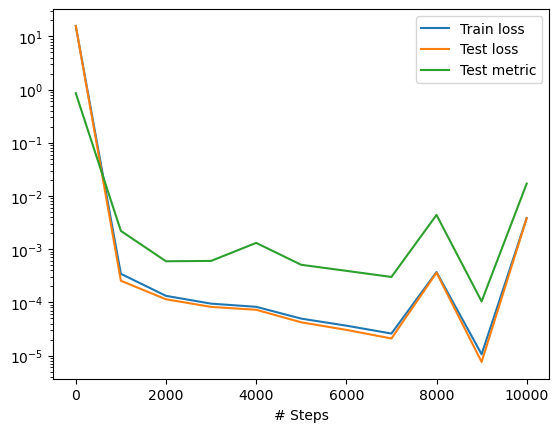

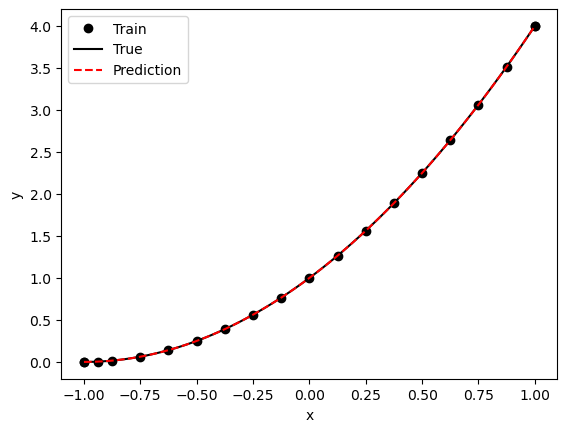

In [15]:
dde.saveplot(loss_histroy, train_state, issave=False, isplot=True)